# Metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyperclip
import math
from utils.logging_metrics import MetricsLogger
import re
from datetime import datetime
import warnings
import numpy as np

RESULT_FOLDER = "metrics/final_results/"
METRICS_LOGGER_FOLDER = "metrics/logged_metrics/"

SET_TYPES = ["test", "train"]
EXPERIMENTS = ["interpolation", "interpolation_coords", "extrapolation", "DTdepth"]#, "OLD"] TODO
VALID_EXPERIMENTS = EXPERIMENTS + ["OLD"]

#TODO fix the following lists
USELESS_METRICS = ["explained_variance_score",
                   "mean_absolute_percentage_error",
                   "median_absolute_error", 
                   "timestamp"]
USEFUL_METRICS = ["r2", "MSE", "MAE",  "Prediction Time"] #"PSNR",
assert set(USELESS_METRICS).isdisjoint(USEFUL_METRICS)
USELESS_MODELS = ["autoencoder"]

METRIC_TO_ABBREVIATION = {
    "r2_score": "r2",
    "explained_variance_score": "EVS",
    "mean_squared_error": "MSE",
    "mean_absolute_error": "MAE",
    "median_absolute_error": "MedAE",
    "mean_absolute_percentage_error": "MAPE",
    "peak_signal_noise_ratio": "PSNR"
}

COLUMNS_TO_BE_MAXIMIZED = ['r2_score', 'explained_variance_score', 'peak_signal_noise_ratio']
COLUMNS_TO_BE_MAXIMIZED += [abb for m, abb in METRIC_TO_ABBREVIATION.items() if m in COLUMNS_TO_BE_MAXIMIZED]
COLUMNS_TO_BE_MINIMIZED = ['prediction_time', 'mean_squared_error', 'mean_absolute_error',
                           'median_absolute_error', 'mean_absolute_percentage_error', 'Prediction Time']
COLUMNS_TO_BE_MINIMIZED += [abb for m, abb in METRIC_TO_ABBREVIATION.items() if m in COLUMNS_TO_BE_MINIMIZED]

pd.set_option('display.max_colwidth', None)

### Training time

In [2]:
def __find_most_recent_metrics_log(model_name: str) -> str | None:
    # code from MetricsLogger conventions
    model_name = re.sub(r'[^a-zA-Z0-9 -_]', '', model_name)\
                    .replace(" ", "-")\
                    .split("_discr_factors")[0]
    matching_files = [file for file in os.listdir(METRICS_LOGGER_FOLDER) if file.startswith(model_name)]
    
    if not matching_files:
        #warnings.warn(f"No files found in {METRICS_LOGGER_FOLDER} with the prefix {model_name}")
        return None
    
    # Sort the files based on their timestamps (assuming the timestamp is at the end of the filename)
    sorted_files = sorted(matching_files,
                          key=lambda file: datetime.strptime(file[-23:-4], "%d-%m-%Y_%H-%M-%S"),
                          reverse=True)
    
    most_recent_metrics_log = os.path.join(METRICS_LOGGER_FOLDER, sorted_files[0])
    return most_recent_metrics_log

def compute_training_time(model_name: str) -> float:
    most_recent_log_file = __find_most_recent_metrics_log(model_name)
    if most_recent_log_file is None:
        return np.nan
    metrics_logger = MetricsLogger.from_csv(most_recent_log_file)
    training_time = metrics_logger.get_training_time('Validation loss')
    if int(training_time) == 0:
        return np.nan
    return training_time

compute_training_time("conv_autoencoders_channels2-4-8-8_kernels3-4-5-5_strides2-2-2-2_paddings1-1-1-1_lin-layers4096-2048-1024-512-256-128-64-32-16-8_consider_ws")

1572

### Loading metrics

In [3]:
def load_metrics(set_type: str, experiment: str,
                 only_model_name: bool = True,
                 columns_to_remove: list = USELESS_METRICS,
                 infer_training_time_attempt: bool = False) -> pd.DataFrame:
    __check_arguments(set_type, experiment)
    filepath = __get_filepath(set_type, experiment)
    metrics = pd.read_csv(filepath)
    # remove uninteresting records
    for model_name in USELESS_MODELS:
        metrics = metrics[~metrics['model_description'].str.contains(model_name)]
    #metrics = metrics[~metrics['model_description'].str.contains('consider_ws')] #TODO ?

    metrics = __remove_duplicates(metrics)
    
    if infer_training_time_attempt: #TODO feature in progress
        metrics["Training Time (s)"] = metrics["model_description"].apply(compute_training_time)

    if only_model_name:
        metrics['model_description'] = metrics['model_description']\
            .str.split("_").str[:2].str.join(" ")\
            .apply(__first_capital)
        metrics.rename(columns={"model_description": "model_name"}, inplace=True)
        metrics.sort_values(by="model_name")
    else:
        metrics.sort_values(by="model_description")
    
    if columns_to_remove:
        metrics.drop(columns_to_remove, axis=1, inplace=True)

    return metrics.rename(columns=__rename_column)        

def __check_arguments(set_type: str | None = None,
                      experiment: str | None = None,
                      metric: str | None = None) -> None:
    if set_type and set_type not in SET_TYPES:
        raise ValueError("set_type should be 'train' or 'test'")
    if experiment and experiment not in VALID_EXPERIMENTS:
        raise ValueError("experiment argument not valid")
    if metric and metric not in METRIC_TO_ABBREVIATION.values():
        raise ValueError(f"Not a valid (abbreviated) metric, choose among: {METRIC_TO_ABBREVIATION.values()}")

def __get_filepath(set_type: str, experiment: str) -> str:
    __check_arguments(set_type, experiment)
    filename = "_".join([set_type + "set", "results", experiment]) + ".csv"
    return os.path.join(RESULT_FOLDER, filename)

def __remove_duplicates(df: pd.DataFrame) -> pd.DataFrame: #choosing the best according to MSE
    groups = df.groupby('model_description')

    # Find the row with minimum MSE for each group
    best_records = groups.apply(lambda group: group.loc[group['mean_squared_error'].idxmin()])

    # Keep only the best records in the DataFrame
    df = best_records.reset_index(drop=True)

    return df

def __rename_column(column_name: str) -> str:
    if column_name in METRIC_TO_ABBREVIATION.keys():
        return METRIC_TO_ABBREVIATION[column_name]
    return column_name.replace("_", " ").title()

def __first_capital(value: str) -> str:
    return value[0].upper() + value[1:]

def compare_metrics(set_type1: str, experiment1: str, set_type2: str, experiment2: str, by_name:bool) -> pd.DataFrame:
    if set_type1 == set_type2 and experiment1 == experiment2:
        raise ValueError("types and experiments are the same -> impossible to merge")
    
    metrics1 = load_metrics(set_type1, experiment1, only_model_name=by_name)
    metrics2 = load_metrics(set_type2, experiment2, only_model_name=by_name)

    if set_type1 != set_type2 and experiment1 == experiment2:
        suffix1 = f" ({set_type1})"
        suffix2 = f" ({set_type2})"
    elif set_type1 == set_type2 and experiment1 != experiment2:
        suffix1 = f" ({experiment1})"
        suffix2 = f" ({experiment2})"
    elif set_type1 != set_type2 and experiment1 != experiment2:
        suffix1 = f" ({set_type1}, {experiment1})"
        suffix2 = f" ({set_type2}, {experiment2})"
    
    return merge_metrics(metrics1, metrics2, suffix1, suffix2, by_name)

def merge_metrics(metrics1: pd.DataFrame, metrics2: pd.DataFrame,
                  suffix1: str, suffix2: str,
                  by_name: bool) -> pd.DataFrame:
    if by_name:
        merge_on = "Model Name"
    else:
        merge_on = "Model Description"
    return pd.merge(metrics1, metrics2, on=merge_on, suffixes=(suffix1, suffix2))\
        .set_index(merge_on)\
        .sort_index(axis=1)\
        .reset_index()\
        .sort_values(by=merge_on)

def load_all_metrics(set_type: str, experiments: list[str] = EXPERIMENTS,
                     columns_to_remove: list = USELESS_METRICS,
                     infer_training_time_attempt: bool = False) -> pd.DataFrame:
    #TODO update method including with more set types?
    # the problem is that the information about the type is not contained
    # anywhere but in the name of the file
    all_metrics = list()
    for experiment in experiments:
        metrics = load_metrics(set_type, experiment,
                                only_model_name=False,
                                columns_to_remove=columns_to_remove)
        all_metrics.append(metrics)
    
    all_metrics = pd.concat(all_metrics).reset_index(drop=True)
    
    if infer_training_time_attempt: #TODO feature in progress
        all_metrics["Training Time (s)"] = all_metrics["Model Description"].apply(compute_training_time)
    return all_metrics.sort_values(by="Model Description")

def load_metrics_by_model(model_name: str, set_type: str, experiments: list[str] = EXPERIMENTS,
                          columns_to_remove: list = USELESS_METRICS,
                          infer_training_time_attempt: bool = False):
    model_name = model_name.lower().replace(" ", "_")
    
    all_metrics = load_all_metrics(set_type,
                                   experiments=experiments,
                                   columns_to_remove=columns_to_remove,
                                   infer_training_time_attempt=infer_training_time_attempt)
    all_metrics= all_metrics[all_metrics["Model Description"].str.lower().str.contains(model_name)]
    return all_metrics.sort_values(by="Model Description")

def best_model_per_algo(by_metric: str, set_type: str):
    __check_arguments(set_type=set_type, metric=by_metric)
    all_metrics = load_all_metrics(set_type)
    return best_model_per_algo_in_df(all_metrics, by_metric=by_metric)

def best_model_per_algo_in_df(df: pd.DataFrame, by_metric: str, metric_name: str = None):
    __check_arguments(metric=by_metric)
    if metric_name==None:
        metric_name = by_metric
    # add a colum to group the models on
    df["Model Name"] = df['Model Description']\
        .str.split("_").str[:2].str.join(" ")\
        .apply(__first_capital)
    # group
    if by_metric in COLUMNS_TO_BE_MAXIMIZED:
        group = df.loc[df.groupby("Model Name")[metric_name].idxmax()]
    elif by_metric in COLUMNS_TO_BE_MINIMIZED:
        group = df.loc[df.groupby("Model Name")[metric_name].idxmin()]
    else:
        raise ValueError("metric not found")
        
    return group.set_index("Model Name")\
        .reset_index()\
        .sort_values(by="Model Name")

### Other comparisons

In [21]:
def extract_parameter(metrics_df: pd.DataFrame,
                      parameter_names: list[str],
                      parameter_type: type,
                      regex: str) -> pd.DataFrame:
    # example of regex: r"approxGP_(\d+)fourier"
    metrics_df[parameter_names] = metrics_df["Model Description"].str.extract(regex)\
        .astype(parameter_type)
    metrics_df.sort_values(by=parameter_names, inplace=True)
    return metrics_df

def extract_reduction_factors(metrics_df: pd.DataFrame, also_coords : bool = False):
    regex = r"training_factors="
    vars = ["ti", "ct"]
    if also_coords:
        vars += ["xD", "yD"]
    for var in vars:
        parameter_name = f"reduction factor {var}"
        regex = regex.replace("(", "").replace(")", "") + var + r"(\d+)"
        metrics_df = extract_parameter(metrics_df,
                                    parameter_names=[parameter_name],
                                    parameter_type=int, regex=regex)
        regex += "-"
    return metrics_df

def extract_reduction_ranges(metrics_df: pd.DataFrame, also_coords : bool = False):
    # training_ranges=ti0.15-0.4-ct0.3-0.7
    #r"ti([\d.]+)-([\d.]+)-ct([\d.]+)-([\d.]+)"
    regex = r"training_ranges="
    vars = ["ti", "ct"]
    if also_coords:
        vars += ["xD", "yD"]
    for var in vars:
        parameter_names = [f"a_{var}", f"b_{var}"]
        regex = regex.replace("(", "").replace(")", "") + var + r"([\d.]+)-([\d.]+)"
        metrics_df = extract_parameter(metrics_df,
                                       parameter_names=parameter_names,
                                       parameter_type=float, regex=regex)
        regex += "-"
    return metrics_df

#TODO move this method in "plotting.py"
def plot_metrics_per_parameter(metrics_df: pd.DataFrame, parameter_name: str,
                               metrics_to_plot: list[str] | None = None): #TODO change
    if metrics_to_plot:
        for metric in metrics_to_plot:
            if metric not in USEFUL_METRICS:
                raise ValueError("Metric to plot not valid")
    else:
        metrics_to_plot = USEFUL_METRICS
    ax = plt.gca()
    colors = plt.cm.tab10.colors

    for i, column in enumerate(metrics_to_plot):
        ax.plot(metrics_df[parameter_name], metrics_df[column], label=column, color=colors[i % len(colors)])

    model_name = "".join(metrics_df["Model Description"].iloc[1].split("_")[:2])
    
    plt.xlabel(parameter_name)
    plt.ylabel('Metric value')
    plt.title(f'Results on {model_name} as {parameter_name} increases')
    plt.legend()
    plt.show()

### To Latex

In [5]:
"""
def print_latex_table_code__(df: pd.DataFrame) -> None:
    latex_table = df.style.hide(axis="index").to_latex(escape=False)
    #.set_table_styles(
    #    [{'selector': 'thead', 'props': [('background-color', '#606060'), ('color', 'white')]}]
    #)
    
    print(latex_table)
"""

def print_copy_latex_table_code(metrics: pd.DataFrame,
                                digits_after_dec: int = 4,
                                bolden_best_value: bool = False,
                                column_format: str | None = None) -> None:
    if bolden_best_value:
        for column in metrics.columns:
            if column in COLUMNS_TO_BE_MAXIMIZED or column.split(" ")[0] in COLUMNS_TO_BE_MAXIMIZED:
                metrics[column] = __format_highest_value_bold(metrics[column], digits_after_dec=digits_after_dec)
            elif column in COLUMNS_TO_BE_MINIMIZED or column.split(" ")[0] in COLUMNS_TO_BE_MINIMIZED:
                metrics[column] = __format_lowest_value_bold(metrics[column], digits_after_dec=digits_after_dec)
    
    formatted_columns = [rf'\textbf{{{col}}}' for col in metrics.columns]
    latex_table = metrics.to_latex(index=False, escape=False, column_format=column_format,
                                   header=formatted_columns)#, float_format=f"%.{digits_after_dec}f")
    
    # copy to clipboard
    pyperclip.copy(latex_table)

    print(latex_table)

def __format_highest_value_bold(values, digits_after_dec: int):
    max_value = values.max()
    return [__format_float(val, bold_value=max_value, digits_after_dec=digits_after_dec) for val in values]

def __format_lowest_value_bold(values, digits_after_dec: int):
    min_value = values.min()
    return [__format_float(val, bold_value=min_value, digits_after_dec=digits_after_dec) for val in values]

def __format_float(value: float, bold_value: float, digits_after_dec: int) -> str:
    if not isinstance(value, float):
        
        return value
    if value == 0.0:
        return "0"
    if pd.isna(value):
        return "N/A"

    exponent = abs(int(math.log10(abs(value))))

    if exponent >= digits_after_dec:
        digits_after_dec = max(digits_after_dec - 3, 0)
        formatted_str = "{:.{digits}e}".format(value, digits=digits_after_dec)
        # Remove unnecessary 0 in the exponent
        formatted_str = formatted_str.replace("e+0", "e+").replace("e-0", "e-")
    else:
        formatted_str = "{:.{digits}f}".format(value, digits=digits_after_dec)
    
    if value==bold_value:
        formatted_str = rf'\textbf{{{formatted_str}}}'

    return formatted_str


# Examples

In [6]:
# metrics of different models on the same experiment (including different reduction factors)
metrics = load_metrics(set_type="test", experiment="interpolation",
                        only_model_name = False, infer_training_time_attempt = False)
#print_copy_latex_table_code(metrics, digits_after_dec=4, bolden_best_value=True)
metrics["consider_ws"] = metrics["Model Description"].str.contains("consider_ws")
metrics.sort_values(by=["consider_ws", "r2"], inplace=True)
metrics

,Model Description,Prediction Time,r2,MSE,MAE,PSNR,consider_ws
2,multivariate_skGP_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 standard multivariate GP,1.375928e-04,-2.121437,1.509570e-03,0.019704,NaN,False
7,univariate_DT_max-depthNone_training_factors=ti64-ct64_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,9.142583e-08,0.051886,1.069481e-03,0.012954,29.708271,False
9,univariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,7.066251e-09,0.208263,8.878001e-04,0.014696,NaN,False
18,univariate_approxGP_32fourier-components_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.955143e-07,0.585889,4.643563e-04,0.011302,NaN,False
5,univariate_DT_max-depthNone_training_factors=ti32-ct32_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,9.508933e-08,0.720661,3.078044e-04,0.006526,35.117252,False
0,multivariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.904947e-05,0.751825,1.737894e-04,0.006313,NaN,False
4,univariate_DT_max-depthNone_training_factors=ti16-ct16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.162149e-07,0.917929,9.244115e-05,0.003185,40.341347,False
3,univariate_DT_max-depth20_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.434563e-07,0.952225,5.234367e-05,0.002340,42.811359,False
8,univariate_DT_max-depthNone_training_factors=ti8-ct8_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.225518e-07,0.978007,2.434801e-05,0.001574,46.135365,False
12,"univariate_NeRF_256fourier-features_layers256-256-256_training_factors=ti16-ct16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.0001)",6.889001e-06,0.979731,2.283035e-05,0.002547,46.414875,False


In [ ]:
# same model with different parameters in different experiments
df = load_metrics_by_model(model_name="univariate DT", set_type="test", experiments=EXPERIMENTS,
                            columns_to_remove=USELESS_METRICS, infer_training_time_attempt = False)
df

,Model Description,Prediction Time,r2,MSE,MAE,PSNR
40,univariate_DT_max-depth10_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.455812e-08,0.925685,0.000083,0.003408,40.791911
41,univariate_DT_max-depth10_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.132028e-08,0.675782,0.000373,0.008432,34.282663
42,univariate_DT_max-depth15_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.983972e-08,0.981968,0.000020,0.001509,46.942263
43,univariate_DT_max-depth15_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.384528e-08,0.763035,0.000273,0.007010,35.644182
3,univariate_DT_max-depth20_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.434563e-07,0.952225,0.000052,0.002340,42.811359
44,univariate_DT_max-depth20_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.066659e-07,0.992913,0.000008,0.000890,50.998065
45,univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.309673e-07,0.799313,0.000231,0.006430,36.365828
33,univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.163276e-07,0.799313,0.000231,0.006430,36.365828
46,univariate_DT_max-depth5_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.123780e-08,0.642088,0.000401,0.008442,33.964889
47,univariate_DT_max-depth5_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,2.540628e-08,0.327415,0.000774,0.013004,31.113557


In [ ]:
# comparison between two experiments merging the models 
# (in case of many attempts with the same model for eadh experiment, all the combinations are considered)
comparison = compare_metrics("test", "interpolation", "test", "extrapolation", by_name=True)
comparison

,Model Name,MAE (extrapolation),MAE (interpolation),MSE (extrapolation),MSE (interpolation),PSNR (extrapolation),PSNR (interpolation),Prediction Time (extrapolation),Prediction Time (interpolation),r2 (extrapolation),r2 (interpolation)
0,Multivariate LR,0.011409,0.006313,0.000584,1.737894e-04,NaN,NaN,1.781648e-05,3.904947e-05,0.188079,0.751825
1,Multivariate NN,0.008371,0.000436,0.000186,6.211153e-07,NaN,NaN,5.630651e-05,4.728596e-05,-4.397790,0.990139
12,Univariate DT,0.006430,0.001574,0.000231,2.434801e-05,36.365828,46.135365,1.163276e-07,1.225518e-07,0.799313,0.978007
11,Univariate DT,0.008773,0.012954,0.000355,1.069481e-03,NaN,29.708271,1.879168e-07,9.142583e-08,0.691732,0.051886
10,Univariate DT,0.006430,0.012954,0.000231,1.069481e-03,36.365828,29.708271,1.163276e-07,9.142583e-08,0.799313,0.051886
9,Univariate DT,0.008773,0.000950,0.000355,7.146157e-06,NaN,51.677291,1.879168e-07,1.280348e-07,0.691732,0.993627
8,Univariate DT,0.006430,0.000950,0.000231,7.146157e-06,36.365828,51.677291,1.163276e-07,1.280348e-07,0.799313,0.993627
13,Univariate DT,0.008773,0.001574,0.000355,2.434801e-05,NaN,46.135365,1.879168e-07,1.225518e-07,0.691732,0.978007
6,Univariate DT,0.006430,0.006526,0.000231,3.078044e-04,36.365828,35.117252,1.163276e-07,9.508933e-08,0.799313,0.720661
5,Univariate DT,0.008773,0.003185,0.000355,9.244115e-05,NaN,40.341347,1.879168e-07,1.162149e-07,0.691732,0.917929


In [ ]:
# for each algorithm, the best model
best_model_per_algo("r2", "test")

,Model Name,Model Description,Prediction Time,r2,MSE,MAE,PSNR
0,Multivariate LR,multivariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.904947e-05,0.751825,1.737894e-04,0.006313,NaN
1,Multivariate NN,"multivariate_NN_layers50-500_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)",4.728596e-05,0.990139,6.211153e-07,0.000436,NaN
2,Multivariate skGP,multivariate_skGP_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 standard multivariate GP,1.375928e-04,-2.121437,1.509570e-03,0.019704,NaN
3,Univariate DT,univariate_DT_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.715937e-07,0.993939,6.796274e-06,0.000813,51.677291
4,Univariate LR,univariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,7.066251e-09,0.208263,8.878001e-04,0.014696,NaN
5,Univariate NN,"univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=1e-05)",4.893259e-06,0.997851,2.410038e-06,0.001021,NaN
6,Univariate NeRF,"univariate_NeRF_256fourier-features_layers256-256-256_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.0001)",6.675190e-06,0.999594,4.548841e-07,0.000404,63.420993
7,Univariate RF,univariate_RF_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.427764e-05,0.993599,7.178110e-06,0.000950,NaN
8,Univariate XGB,univariate_XGB_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.203391e-07,0.988793,1.256640e-05,0.001553,NaN
9,Univariate approxGP,univariate_approxGP_32fourier-components_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.955143e-07,0.585889,4.643563e-04,0.011302,NaN


In [ ]:
load_all_metrics(set_type="test", experiments=EXPERIMENTS,
                     columns_to_remove = USELESS_METRICS,
                     infer_training_time_attempt = False)

,Model Description,Prediction Time,r2,MSE,MAE,PSNR
0,multivariate_LR_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.904947e-05,0.751825,1.737894e-04,0.006313,NaN
31,multivariate_LR_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.781648e-05,0.188079,5.836411e-04,0.011409,NaN
1,"multivariate_NN_layers50-500_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)",4.728596e-05,0.990139,6.211153e-07,0.000436,NaN
32,"multivariate_NN_layers50-500_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)",5.630651e-05,-4.397790,1.863778e-04,0.008371,NaN
2,multivariate_skGP_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 standard multivariate GP,1.375928e-04,-2.121437,1.509570e-03,0.019704,NaN
40,univariate_DT_max-depth10_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.455812e-08,0.925685,8.333144e-05,0.003408,40.791911
41,univariate_DT_max-depth10_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,3.132028e-08,0.675782,3.730214e-04,0.008432,34.282663
42,univariate_DT_max-depth15_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.983972e-08,0.981968,2.021965e-05,0.001509,46.942263
43,univariate_DT_max-depth15_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.384528e-08,0.763035,2.726351e-04,0.007010,35.644182
3,univariate_DT_max-depth20_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.434563e-07,0.952225,5.234367e-05,0.002340,42.811359


# Results

## Interpolation

In [7]:
# INTERPOLATION - RESULTS
two = list()
for set_type in ["train", "test"]:
    metrics = load_metrics(set_type=set_type, experiment="interpolation",
                            only_model_name = False, infer_training_time_attempt = False)
    #metrics = compare_metrics("train", "interpolation", "test", "interpolation", by_name=False)
    metrics = extract_reduction_factors(metrics, also_coords=False)
    metrics = metrics[metrics["reduction factor ti"]==12]
    toremove_columns = [col for col in metrics.columns \
                        if col.startswith("reduction factor") or col.startswith("Prediction Time")\
                            or col.startswith("MSE") or col.startswith("PSNR")]
    metrics.drop(toremove_columns, axis=1, inplace=True)

    two.append(metrics)

metrics = merge_metrics(two[0], two[1], suffix1=" (train)", suffix2=" (test)", by_name=False)
#metrics = best_model_per_algo_in_df(metrics, "MAE", "MAE (test)")
#metrics = metrics[['Model Name', 'r2 (train)', 'MAE (train)', 'r2 (test)', 'MAE (test)', 'Model Description']]
#print_copy_latex_table_code(metrics, bolden_best_value=True, column_format="lccccl")
metrics

,Model Description,MAE (test),MAE (train),r2 (test),r2 (train)
1,univariate_DT_max-depth20_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.002340,0.000096,0.952225,0.999861
0,"univariate_NeRF_256fourier-features_layers256-256-256_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.0001)",0.001532,0.001706,0.993211,0.994429


### Interpolation - study of DT depth

In [8]:
# INTERPOLATION - DT DEPTH - RESULTS
two = list()
for set_type in ["train", "test"]:
    metrics = load_metrics(set_type=set_type, experiment="DTdepth",
                            only_model_name = False, infer_training_time_attempt = False)
    toremove_columns = [col for col in metrics.columns \
                        if col.startswith("reduction factor") or col.startswith("Prediction Time")\
                            or col.startswith("MSE") or col.startswith("PSNR")]
    metrics.drop(toremove_columns, axis=1, inplace=True)

    two.append(metrics)

metrics = merge_metrics(two[0], two[1], suffix1=" (train)", suffix2=" (test)", by_name=False)
metrics.sort_values(by="Model Description")
#metrics = best_model_per_algo_in_df(metrics, "MAE", "MAE (test)")
metrics = metrics[['Model Description', 'r2 (train)', 'MAE (train)', 'r2 (test)', 'MAE (test)']]
print_copy_latex_table_code(metrics, bolden_best_value=False, column_format="lcccc")
metrics

\begin{tabular}{lcccc}
\toprule
                                                                                              \textbf{Model Description} & \textbf{r2 (train)} & \textbf{MAE (train)} & \textbf{r2 (test)} & \textbf{MAE (test)} \\
\midrule
            univariate_DT_max-depth10_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 &            0.932271 &         3.345600e-03 &           0.925685 &            0.003408 \\
univariate_DT_max-depth10_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 &            0.959916 &         2.581645e-03 &           0.675782 &            0.008432 \\
            univariate_DT_max-depth15_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 &            0.988579 &         1.199203e-03 &           0.981968 &            0.001509 \\
univariate_DT_max-depth15_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_C

/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_6545/662563111.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics.to_latex(index=False, escape=False, column_format=column_format,


,Model Description,r2 (train),MAE (train),r2 (test),MAE (test)
0,univariate_DT_max-depth10_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.932271,3.345600e-03,0.925685,0.003408
1,univariate_DT_max-depth10_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.959916,2.581645e-03,0.675782,0.008432
2,univariate_DT_max-depth15_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.988579,1.199203e-03,0.981968,0.001509
3,univariate_DT_max-depth15_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.992383,1.060495e-03,0.763035,0.007010
4,univariate_DT_max-depth20_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.999046,2.793623e-04,0.992913,0.000890
5,univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.998909,3.730499e-04,0.799313,0.006430
6,univariate_DT_max-depth5_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.633701,8.850931e-03,0.642088,0.008442
7,univariate_DT_max-depth5_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.794169,6.398746e-03,0.327415,0.013004
8,univariate_DT_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.000000,3.197542e-11,0.993939,0.000813


## Interpolation on coords

In [9]:
# INTERPOLATION ON COORDS - RESULTS
two = list()
for set_type in ["train", "test"]:
    metrics = load_metrics(set_type=set_type, experiment="interpolation_coords",
                            only_model_name = False, infer_training_time_attempt = False)
    metrics = extract_reduction_factors(metrics, also_coords=False)
    metrics = metrics[metrics["reduction factor ti"]==16]
    toremove_columns = [col for col in metrics.columns \
                        if col.startswith("Prediction Time")  \
                            or col.startswith("MSE") or col.startswith("PSNR")]
    metrics.drop(toremove_columns, axis=1, inplace=True)

    two.append(metrics)

metrics = merge_metrics(two[0], two[1], suffix1=" (train)", suffix2=" (test)", by_name=False)
metrics = best_model_per_algo_in_df(metrics, "MAE", "MAE (test)")
metrics = metrics[['Model Name', 'r2 (train)', 'MAE (train)', 'r2 (test)', 'MAE (test)', 'Model Description']]
print_copy_latex_table_code(metrics, bolden_best_value=True, column_format="lccccl")
metrics

\begin{tabular}{lccccl}
\toprule
\textbf{Model Name} & \textbf{r2 (train)} & \textbf{MAE (train)} & \textbf{r2 (test)} & \textbf{MAE (test)} &                                                                                                                                                                                                      \textbf{Model Description} \\
\midrule
      Univariate DT &     \textbf{1.0000} &     \textbf{1.9e-10} &            -2.4907 &              0.0222 &                                                                                                      univariate_DT_max-depthNone_training_factors=ti16-ct16-xD16-yD16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 \\
    Univariate NeRF &              0.0078 &               0.0353 &   \textbf{-0.0220} &     \textbf{0.0181} & univariate_NeRF_128fourier-features_layers128-256-32_training_factors=ti16-ct16-xD16-yD16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last

/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_6545/662563111.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics.to_latex(index=False, escape=False, column_format=column_format,


,Model Name,r2 (train),MAE (train),r2 (test),MAE (test),Model Description
0,Univariate DT,\textbf{1.0000},\textbf{1.9e-10},-2.4907,0.0222,univariate_DT_max-depthNone_training_factors=ti16-ct16-xD16-yD16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
1,Univariate NeRF,0.0078,0.0353,\textbf{-0.0220},\textbf{0.0181},"univariate_NeRF_128fourier-features_layers128-256-32_training_factors=ti16-ct16-xD16-yD16_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)"


## Extrapolation

In [10]:
# EXTRAPOLATIONS - RESULTS
two = list()
for set_type in ["train", "test"]:
    metrics = load_metrics(set_type=set_type, experiment="extrapolation",
                            only_model_name = False, infer_training_time_attempt = False)
    metrics = extract_reduction_ranges(metrics, also_coords=False)
    #metrics = metrics[metrics["reduction factor ti"]==4]
    toremove_columns = [col for col in metrics.columns \
                        if col.startswith("a_") or col.startswith("b_")\
                            or col.startswith("Prediction Time")\
                            or col.startswith("MSE") or col.startswith("PSNR")]
    metrics.drop(toremove_columns, axis=1, inplace=True)

    two.append(metrics)

metrics = merge_metrics(two[0], two[1], suffix1=" (train)", suffix2=" (test)", by_name=False)
#metrics = best_model_per_algo_in_df(metrics, "MAE", "MAE (test)")
#metrics = metrics[['Model Name', 'r2 (train)', 'MAE (train)', 'r2 (test)', 'MAE (test)', 'Model Description']]
#print_copy_latex_table_code(metrics, bolden_best_value=True, column_format="lccccl")
metrics

,Model Description,MAE (test),MAE (train),r2 (test),r2 (train)
0,multivariate_LR_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.011409,7.990032e-04,0.188079,0.966449
1,"multivariate_NN_layers50-500_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)",0.008371,4.365573e-04,-4.397790,-9.231921
2,univariate_DT_max-depth20_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.006430,3.730499e-04,0.799313,0.998909
3,univariate_DT_max-depthNone_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.008773,2.685008e-11,0.691732,1.000000
4,univariate_LR_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.015174,1.451148e-02,0.167680,0.169023
5,"univariate_NN_layers50-250_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=1e-05)",0.008828,7.839958e-04,0.689258,0.998659
6,"univariate_NeRF_256fourier-features_layers256-256-256_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.0001)",0.005263,7.792364e-04,0.901258,0.997927
7,"univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)",0.008307,2.120874e-03,0.701598,0.985652
8,univariate_approxGP_32fourier-components_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,0.013076,1.052860e-02,0.446894,0.598674


# Other studies

## Number of components for approximate GP

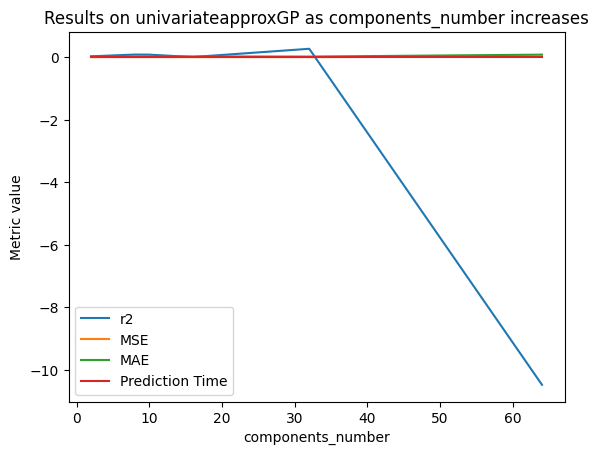

,Model Description,Prediction Time,r2,MSE,MAE,PSNR,components_number
21,univariate_approxGP_2fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,6.557993e-09,0.025679,0.001211,0.016694,NaN,2
23,univariate_approxGP_4fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,4.682481e-09,0.044151,0.001188,0.017479,NaN,4
25,univariate_approxGP_8fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,4.214068e-09,0.081672,0.001142,0.019079,NaN,8
19,univariate_approxGP_10fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.915616e-07,0.078893,0.001145,0.018066,NaN,10
20,univariate_approxGP_16fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,5.935095e-09,0.002538,0.001240,0.020174,NaN,16
22,univariate_approxGP_32fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.063439e-08,0.266360,0.000912,0.016319,NaN,32
24,univariate_approxGP_64fourier-components_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01,1.745479e-06,-10.478075,0.014271,0.078882,NaN,64


In [15]:
"""Study on the number of components approximate GP (needs to consider the records with "consider_ws")"""

metrics = load_metrics_by_model("approxGP", set_type="test", experiments=["OLD"])
metrics = extract_parameter(metrics, parameter_names=["components_number"], parameter_type=int, regex=r"approxGP_(\d+)fourier")
plot_metrics_per_parameter(metrics, "components_number")
metrics

## Study of reduction factors

### Decision Tree - interpolation

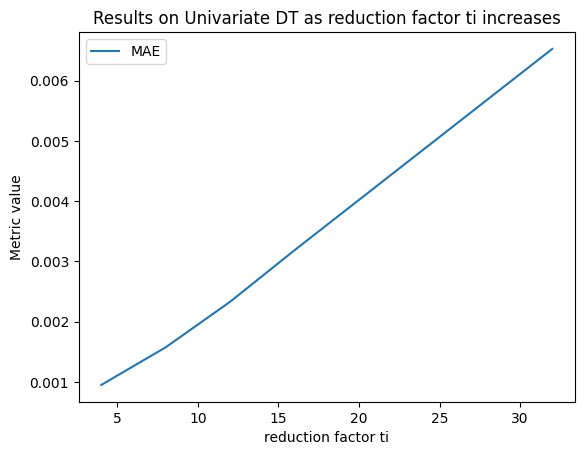

\begin{tabular}{cccc}
\toprule
\textbf{Model Description} & \textbf{r2} & \textbf{MAE} & \textbf{reduction factor ti} & \textbf{Training Percentage} \\
\midrule
             Univariate DT &    0.993627 &     0.000950 &                            4 &       & $ \approx 6.40\%$ \\ \\
             Univariate DT &    0.978007 &     0.001574 &                            8 &       & $ \approx 1.66\%$ \\ \\
             Univariate DT &    0.952426 &     0.002330 &                           12 &       & $ \approx 0.84\%$ \\ \\
             Univariate DT &    0.917929 &     0.003185 &                           16 &       & $ \approx 0.49\%$ \\ \\
             Univariate DT &    0.720661 &     0.006526 &                           32 &       & $ \approx 0.14\%$ \\ \\
\bottomrule
\end{tabular}



/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_6545/662563111.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics.to_latex(index=False, escape=False, column_format=column_format,


,Model Description,r2,MAE,reduction factor ti,Training Percentage
7,Univariate DT,0.993627,0.000950,4,& $ \approx 6.40\%$ \\
9,Univariate DT,0.978007,0.001574,8,& $ \approx 1.66\%$ \\
4,Univariate DT,0.952426,0.002330,12,& $ \approx 0.84\%$ \\
5,Univariate DT,0.917929,0.003185,16,& $ \approx 0.49\%$ \\
6,Univariate DT,0.720661,0.006526,32,& $ \approx 0.14\%$ \\


In [85]:
"""DECISION TREE REDUCTION FACTORS - Study on the training reduction factors for Decision Tree"""

metrics_DT_rf = load_metrics_by_model("DT", set_type="test", experiments=["interpolation"])
metrics_DT_rf = extract_reduction_factors(metrics_DT_rf, also_coords=False)
# leaving only deepest trees
metrics_DT_rf = extract_parameter(metrics_DT_rf, ["depth"], float, regex=r"depth(\d+)_")
metrics_DT_rf = metrics_DT_rf[metrics_DT_rf["depth"].isna()]
metrics_DT_rf.drop("depth", axis=1, inplace=True)
# cleaning the table
metrics_DT_rf["Model Description"] = "Univariate DT"
metrics_DT_rf.drop(["Prediction Time", "MSE", "PSNR", "reduction factor ct"], axis=1, inplace=True)
metrics_DT_rf = metrics_DT_rf[metrics_DT_rf["reduction factor ti"]!=64]

plot_metrics_per_parameter(metrics_DT_rf, "reduction factor ti", metrics_to_plot=["MAE"])
metrics_DT_rf["Training Percentage"] = metrics_DT_rf["reduction factor ti"]\
    .apply(lambda x: f"& $ \\approx {math.ceil(100/x) * math.ceil(86/x)/86:.2f}\\%$ \\\\")
print_copy_latex_table_code(metrics_DT_rf, column_format="cccc")
metrics_DT_rf

### NeRF - interpolation

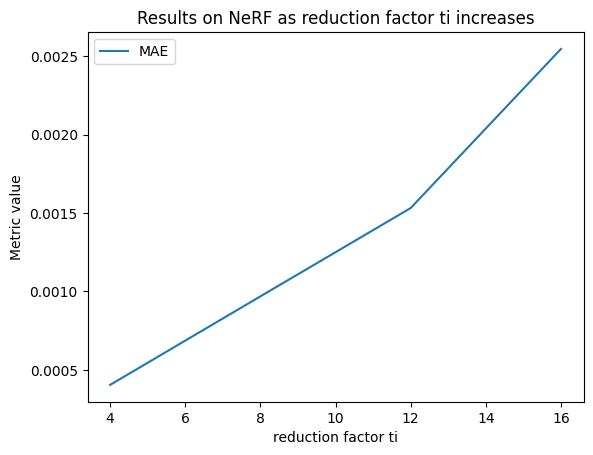

\begin{tabular}{cccc}
\toprule
\textbf{Model Description} & \textbf{r2} & \textbf{MAE} & \textbf{reduction factor ti} & \textbf{Training Percentage} \\
\midrule
                      NeRF &    0.999594 &     0.000404 &                            4 &       & $ \approx 6.40\%$ \\ \\
                      NeRF &    0.997644 &     0.000968 &                            8 &       & $ \approx 1.66\%$ \\ \\
                      NeRF &    0.993211 &     0.001532 &                           12 &       & $ \approx 0.84\%$ \\ \\
                      NeRF &    0.979731 &     0.002547 &                           16 &       & $ \approx 0.49\%$ \\ \\
\bottomrule
\end{tabular}



/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_6545/662563111.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics.to_latex(index=False, escape=False, column_format=column_format,


,Model Description,r2,MAE,reduction factor ti
7,Univariate DT,0.993627,0.000950,4
9,Univariate DT,0.978007,0.001574,8
4,Univariate DT,0.952426,0.002330,12
5,Univariate DT,0.917929,0.003185,16
6,Univariate DT,0.720661,0.006526,32
8,Univariate DT,0.051886,0.012954,64


In [83]:
"""NERF REDUCTION FACTORS - Study on the training reduction factors for NeRF"""

metrics_NeRF_rf = load_metrics_by_model("NeRF", set_type="test", experiments=["interpolation"])
metrics_NeRF_rf = extract_reduction_factors(metrics_NeRF_rf, also_coords=False)
# leaving only best structure
metrics_NeRF_rf = extract_parameter(metrics_NeRF_rf, ["# ff"], int, regex=r"_(\d+)fourier-features")
metrics_NeRF_rf = metrics_NeRF_rf[metrics_NeRF_rf["# ff"] == 256]
metrics_NeRF_rf.drop("# ff", axis=1, inplace=True)
# cleaning the table
metrics_NeRF_rf["Model Description"] = "NeRF"
metrics_NeRF_rf.drop(["Prediction Time", "MSE", "PSNR", "reduction factor ct"], axis=1, inplace=True)

plot_metrics_per_parameter(metrics_NeRF_rf, "reduction factor ti", metrics_to_plot=["MAE"])
metrics_NeRF_rf["Training Percentage"] = metrics_NeRF_rf["reduction factor ti"]\
    .apply(lambda x: f"& $ \\approx {math.ceil(100/x) * math.ceil(86/x)/86:.2f}\\%$ \\\\")
print_copy_latex_table_code(metrics_NeRF_rf, column_format="cccc")
metrics

### Visual Comparison

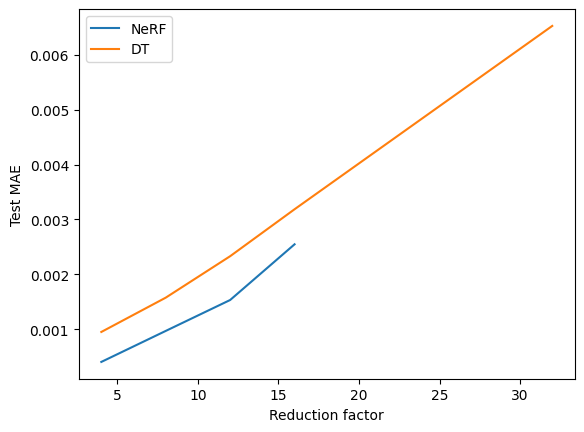

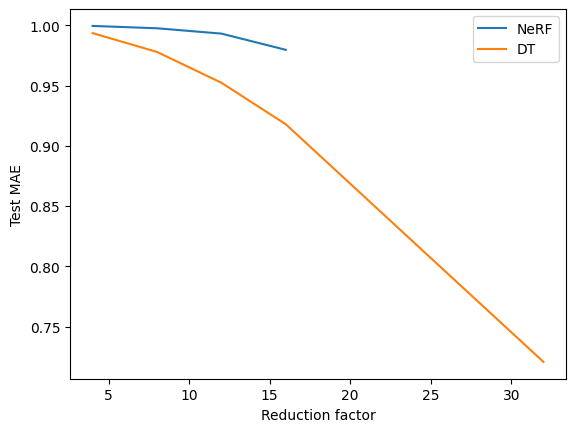

In [86]:
# VISUAL COMPARISON
metric_name = "MAE"
ax = plt.gca()
ax.plot(metrics_NeRF_rf["reduction factor ti"], metrics_NeRF_rf[metric_name], label="NeRF")
ax.plot(metrics_DT_rf["reduction factor ti"], metrics_DT_rf[metric_name], label="DT")
plt.xlabel("Reduction factor")
plt.ylabel('Test MAE')
plt.legend()
plt.show()

metric_name = "r2"
ax = plt.gca()
ax.plot(metrics_NeRF_rf["reduction factor ti"], metrics_NeRF_rf[metric_name], label="NeRF")
ax.plot(metrics_DT_rf["reduction factor ti"], metrics_DT_rf[metric_name], label="DT")
plt.xlabel("Reduction factor")
plt.ylabel('Test MAE')
plt.legend()
plt.show()

In [18]:
stopper

NameError: name 'stopper' is not defined

# Attempt TODO and to settle

In [ ]:
from utils.data_loaders import get_wake_datasets
import torch
import torch.nn as nn
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

MODEL_FOLDER_OLD = "saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/"
MODEL_FOLDER = "saved_models/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01/"

DATA_FOLDER = f"data/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"

INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}


In [ ]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(
    DATA_FOLDER,
    consider_ws=False,
    coords_as_input=True,
    input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
    #input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
)
del valid_dataset

num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:328: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


In [ ]:
input_space = test_dataset.inputs.shape[1]
output_space = test_dataset.outputs.shape[1]

models = list()
model_descs = list()
model_colors = ["crimson", "mediumblue", "green", "mediumorchid"]

# UNIVARIATE NN
hidden_layers_units = [50, 250]
activation_function = nn.ReLU()
class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        layer_units = [input_space] + hidden_layers_units
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), activation_function]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)
model_path = os.path.join(MODEL_FOLDER, "univariate_NN_layers50-250_training_factors=ti4-ct4.pt")
model_desc = "Univariate MLP - normal interpolation"

model = UnivariateNN(input_space, output_space)
model.load_state_dict(torch.load(model_path))
model.eval()

models.append(model)
model_descs.append(model_desc)

# NeRF
n_mapping = 256
hidden_layers_units = [256,256,256]
class FourierLayer(nn.Module):
    def __init__(self, n_features: int, n_mapping: int):
        super(FourierLayer, self).__init__()
        self.coefficients = nn.Parameter(torch.randn(n_mapping, n_features)) # sampled from normal distribution with mean 0 and variance 1 

    def forward(self, x):
        x_proj = 2 * torch.pi * x @ self.coefficients.t()
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

class NeRF2D(nn.Module):
    def __init__(self, n_coordinates: int, n_features: int, output_space: int):
        super(NeRF2D, self).__init__()
        self.fourier_layer = FourierLayer(n_coordinates, n_mapping)
        layer_units = [n_mapping * 2 + n_features] + hidden_layers_units
        mlp_layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            mlp_layers += [nn.Linear(first, second), activation_function]
        mlp_layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, inputs):
        # Pass coordinates through the Fourier Layer
        coords = inputs[:, -2:]
        input_features = inputs[:, :-2]
        fourier_out = self.fourier_layer(coords)

        # Concatenate Fourier layer output with other input features
        input_features = torch.cat((fourier_out, input_features), dim=-1)

        # Feed-forward through the rest of the neural network
        x = self.mlp(input_features)

        return x
model_path = os.path.join(MODEL_FOLDER, "univariate_NeRF_256fourier-features_layers256-256-256_training_factors=ti4-ct4.pt")
model_desc = "NeRF 256 - normal interpolation"

model = NeRF2D(n_coordinates=2, n_features=2, output_space=1)
model.load_state_dict(torch.load(model_path))
model.eval()

models.append(model)
model_descs.append(model_desc)

# DECISION TREE
model = DecisionTreeRegressor()
model.fit(train_dataset.inputs, train_dataset.outputs)
model_desc = "Decision Tree - normal interpolation"
models.append(model)
model_descs.append(model_desc)

# LINEAR REGRESSION
model = LinearRegression()
model.fit(train_dataset.inputs, train_dataset.outputs)
model_desc = "Linear Regression - normal interpolation"
models.append(model)
model_descs.append(model_desc)

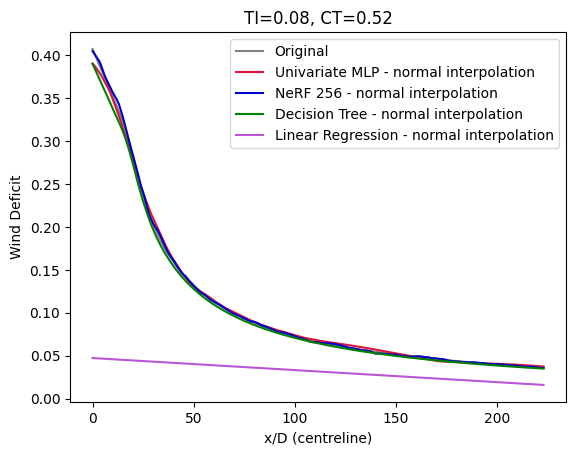

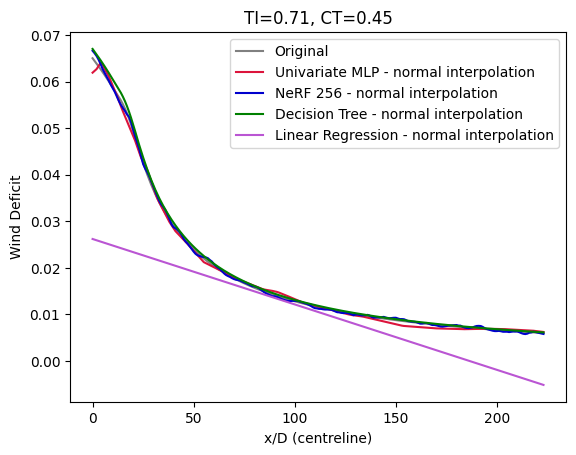

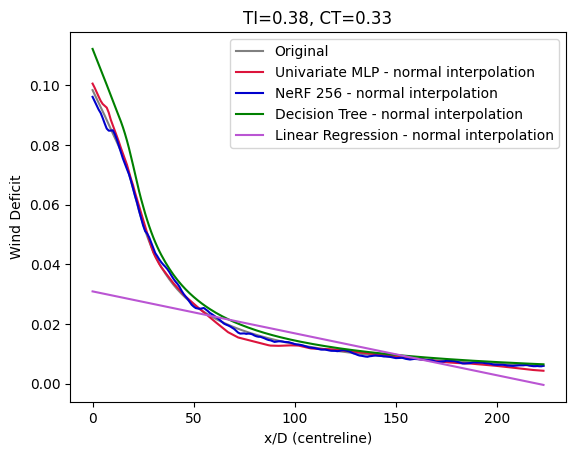

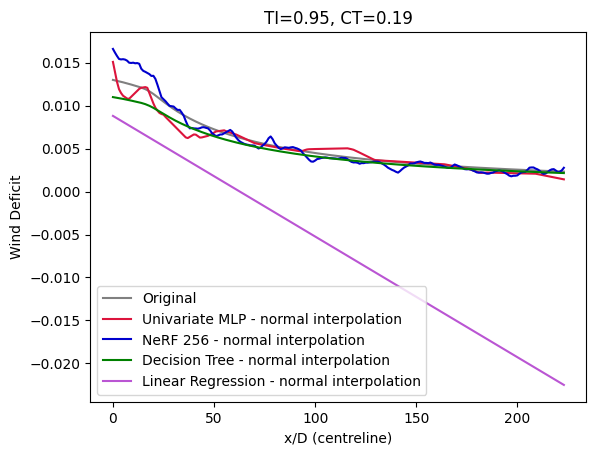

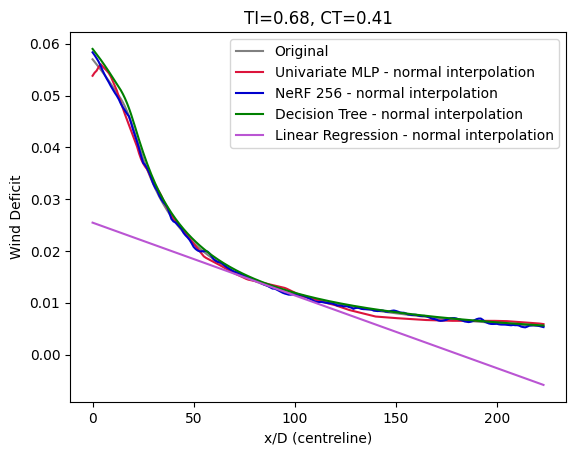

In [ ]:
random.shuffle(field_indices)

for field_idx in field_indices[:5]: #TODO
    plt.figure()
    init = True
    for i, model in enumerate(models):
        ti, ct, _, wake_field, predicted_wake_field = \
            test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        
        # TODO move this stuff to plotting.py
        original_centerline = wake_field[:, 16:17].squeeze(1).detach().numpy()
        predicted_centerline = predicted_wake_field[:, 16:17].squeeze(1).detach().numpy()
        if init:
            # plot original
            plt.plot(original_centerline, label=f'Original', color='grey')
            init = False

        # Plot predicted_centerline
        plt.plot(predicted_centerline, label=model_descs[i], color=model_colors[i])

        plt.xlabel('x/D (centreline)')
        plt.ylabel('Wind Deficit')
        plt.title(f"TI={ti:.2f}, CT={ct:.2f}")
        plt.legend()
        # TODO end

    plt.show()  # Show the plot for each field_idx